In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import ipywidgets as widgets
from scipy.signal import butter, lfilter
from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import freqz
from IPython.display import display


%matplotlib widget

### Define plotting functions ###

In [2]:
def plot_audio_time_domain(audio, sample_rate):

    channels = audio.shape[1] if audio.ndim > 1 else 1
    time = np.linspace(0., len(audio) / sample_rate, len(audio))

    plt.figure(figsize=(15, 5))
    for i in range(channels):
        plt.subplot(2, 1, i+1)
        plt.plot(time, audio[:, i])
        plt.title('Channel %d' % (i+1))
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()



def plot_audio_freq_domain(audio, sample_rate):
    channels = audio.shape[1] if audio.ndim > 1 else 1
    plt.figure(figsize=(15, 5))
    for i in range(channels):
        channel_data = audio[:, i]
        
        #FFT
        yf = fft(channel_data)
        xf = np.linspace(0, sample_rate//2, len(channel_data)//2)
        
        idx_range = np.where(xf<=10000)
        xf_zoom = xf[idx_range]
        yf_zoom = yf[idx_range]
        plt.subplot(2, 1, i+1)
        plt.plot(xf_zoom, 2.0/len(channel_data) * np.abs(yf_zoom))
        
        plt.title('Frequency Domain of Channel %d' % (i+1))
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()



def plot_filter_frequency_response(b, a, fs):
    # Plot the frequency response of the filter.
    w, h = freqz(b, a, worN=8000)
    w = w * fs / (2 * np.pi)  # Convert from rad/sample to Hz

    plt.figure(figsize=(15, 5))
    plt.plot(w, 20 * np.log10(np.abs(h)), 'b')
    plt.title('Filter Frequency Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain [dB]')
    plt.grid()
    plt.show()

### Read audio data ###

In [3]:
sample_rate, audio = wavfile.read(r"C:\Users\LinhNguyen\Desktop\BA_Code\580527__tosha73__big-city-noise-15072021.wav")

C:\Users\LinhNguyen\AppData\Local\Temp\ipykernel_6260\904692375.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = wavfile.read(r"C:\Users\LinhNguyen\Desktop\BA_Code\580527__tosha73__big-city-noise-15072021.wav")


### Define butterworth filter ###

In [4]:
def butter_lowpass(audio, cutoff, fs, order=1):
    num, den = butter(order, cutoff, btype="low", analog=False, output="ba", fs=fs)
    plot_filter_frequency_response(num, den, fs)
    
    if audio.ndim == 1:  # Mono audio
        audio_filtered = lfilter(num, den, audio)
    else:  # Stereo audio
        audio_filtered = np.vstack([
            lfilter(num, den, audio[:, 0]),
            lfilter(num, den, audio[:, 1])
        ]).T  # Transpose back to the original shape
    return audio_filtered



### Filter Audio ###


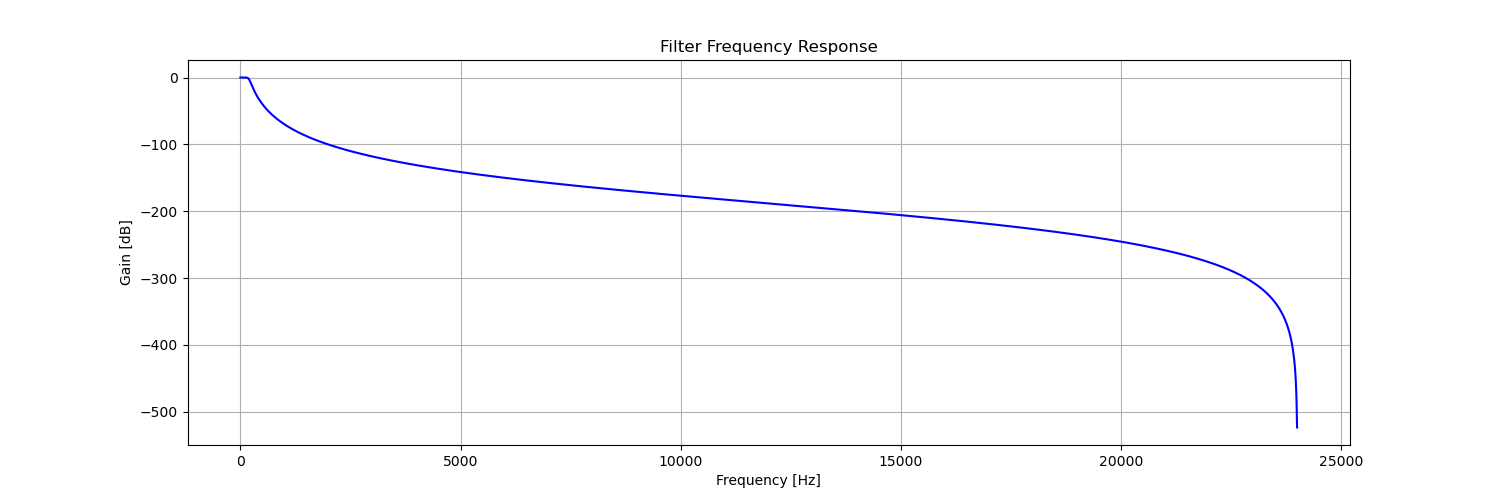

In [5]:
y_low = butter_lowpass(audio, 200, sample_rate, 5)

### Plot original audio (frequency domain) ###

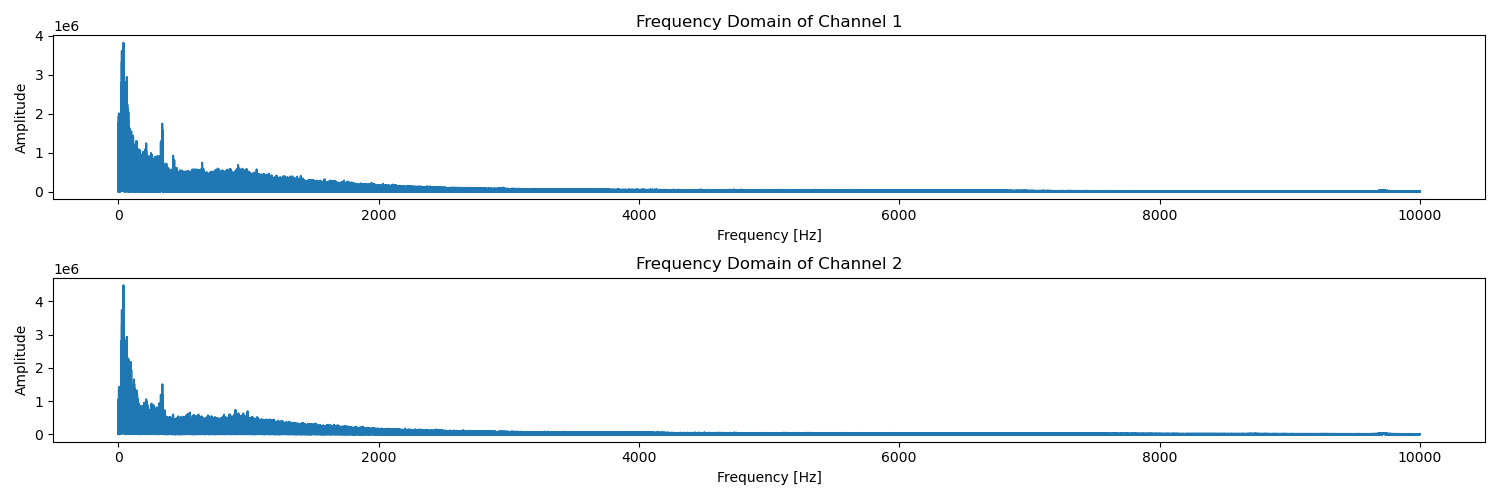

In [6]:
plot_audio_freq_domain(audio, sample_rate)

### Plot filtered audio (freqeuncy domain) ###

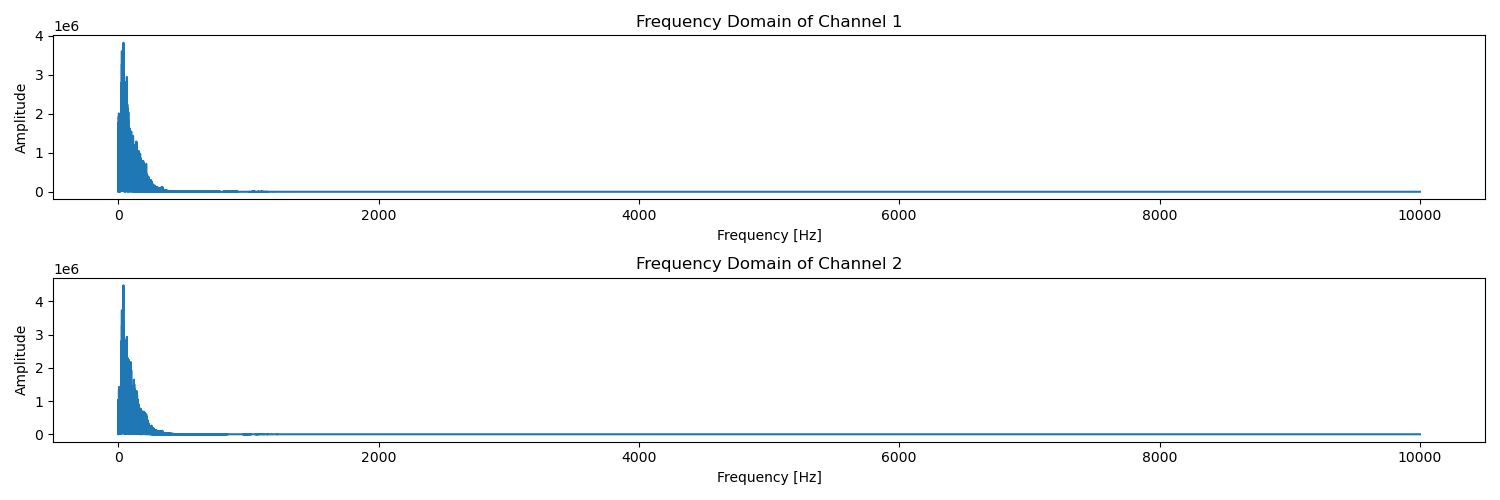

In [7]:
plot_audio_freq_domain(y_low, sample_rate)

### Define Playback Functions ###

In [8]:
def play_audio(audio, sample_rate):
    sd.play(audio, sample_rate)
    print("Audio is playing...")

def stop_audio():
    sd.stop()
    print("Audio stopped.")


### Play original audio ###

In [11]:
print(sd.query_devices())
sd.default.device = 18

play_audio(audio, sample_rate)

   0 Microsoft Soundmapper - Input, MME (2 in, 0 out)
   1 Microphone Array (AMD Audio Dev, MME (2 in, 0 out)
   2 Microsoft Soundmapper - Output, MME (0 in, 2 out)
   3 Realtek HD Audio 2nd output (Re, MME (0 in, 2 out)
   4 Lautsprecher (Realtek(R) Audio), MME (0 in, 2 out)
   5 Primärer Soundaufnahmetreiber, Windows DirectSound (2 in, 0 out)
   6 Microphone Array (AMD Audio Device), Windows DirectSound (2 in, 0 out)
   7 Primärer Soundtreiber, Windows DirectSound (0 in, 2 out)
   8 Realtek HD Audio 2nd output (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
   9 Lautsprecher (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
  10 Lautsprecher (Realtek(R) Audio), Windows WASAPI (0 in, 2 out)
  11 Realtek HD Audio 2nd output (Realtek(R) Audio), Windows WASAPI (0 in, 2 out)
  12 Microphone Array (AMD Audio Device), Windows WASAPI (2 in, 0 out)
  13 Mikrofon (Realtek HD Audio Mic input), Windows WDM-KS (2 in, 0 out)
  14 Speakers 1 (Realtek HD Audio output with HAP), Windows WDM

### Play filtered audio ###

In [13]:
play_audio(y_low, sample_rate)

Playing audio... Press Ctrl+C to stop.
